In [1]:
from __future__ import division
import datetime
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [2]:
def market_design(param):
    # Create a range of ratio
    ratios = numpy.linspace(0.1, param['ratio_end'], num=param['ratio_num'])

    # Create vectors
    sells = []
    buys = []
    PVprods = []
    LOADconss = []
    for ratio in ratios:
        # Fake Load and PV
        PVprod = 10
        LOADcons = ratio * PVprod

        # Clear price
        buy, sell = ratio_to_price(ratio, param)
        sells.append(sell)
        buys.append(buy)
        PVprods.append(PVprod)
        LOADconss.append(LOADcons)
    
    # Create plots
    plot_prices(ratios, sells, buys, PVprods, LOADconss, param)

def ratio_to_price(ratio, param):
    """Clearing price mechanism"""
    # Retailing price $/kW
    pge = param['pge']

    # Upper/lower margin coef
    upper_ratio = param['upper_ratio']
    lower_ratio = param['lower_ratio']

    # Maximum local electricity price
    maximum_local_buy = param['maximum_local_buy']
    maximum_local_sell = param['maximum_local_sell']

    # Minimum local electricity prices
    minimum_local_buy = param['minimum_local_buy']
    minimum_local_sell = param['minimum_local_sell']

    # If no feed back to main grid
    if ratio >= upper_ratio:
        # Selling price
        sell = maximum_local_sell

        # Buying price
        # buy = ((maximum_local_sell * PVprod) + (pge * (LOADcons - PVprod))) / LOADcons
        buy = maximum_local_sell * 1 /ratio + pge * (1 - 1 /ratio)

    # RE production is around 66%
    elif ratio < upper_ratio and ratio >= lower_ratio:
        # Selling price
        a = (maximum_local_sell - minimum_local_sell) / (upper_ratio - lower_ratio)
        b = minimum_local_sell - a * lower_ratio
        sell = a * ratio + b

        # Buying price
#         a = (maximum_local_buy - minimum_local_buy) / (upper_ratio - lower_ratio)
#         b = minimum_local_buy - a * lower_ratio
#         buy = a * ratio + b
        buy = sell * 1 /ratio + pge * (1 - 1 /ratio)

    # RE production is bigger than local needs
    else:
        sell = minimum_local_sell
        buy = minimum_local_buy


    return buy, sell

def plot_prices(ratios, sells, buys, PVprods, LOADconss, param):
    # Check buy and sell match
    localProdPrice = [PVprods[i] * sells[i] for i in range(0, len(sells))]
    pgePrice = [(LOADconss[i] - PVprods[i]) * param['pge'] for i in range(0, len(sells))]
    localConsPrice = [LOADconss[i] * buys[i] for i in range(0, len(sells))]
    totalConsPrice = [localProdPrice[i] + pgePrice[i] for i in range(0, len(ratios))]

    # Plot price for different ratios
    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(ratios, buys, label='buying price')
    plt.plot(ratios, sells, label='selling price')
    plt.plot(ratios, [param['pge']] * len(ratios), label='PGE price')
    plt.ylabel('Price [$/kW]')
    plt.xlabel('Ratio [Consumption/Generation]')
    plt.legend(loc=0)

    # Plot 
    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(ratios, localProdPrice, label='price to local gen')
    plt.plot(ratios, pgePrice, label='price to pge')
    plt.plot(ratios, localConsPrice, label='price from local consumer')
    plt.plot(ratios, totalConsPrice, label='price from pge + price to local prod', linewidth=4, alpha=0.8)
    plt.ylabel('Price $')
    plt.xlabel('Ratio [Consumption/Generation]')
    plt.legend(loc=0)
    plt.show()


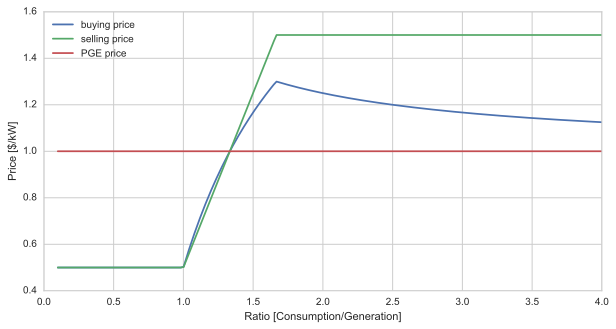

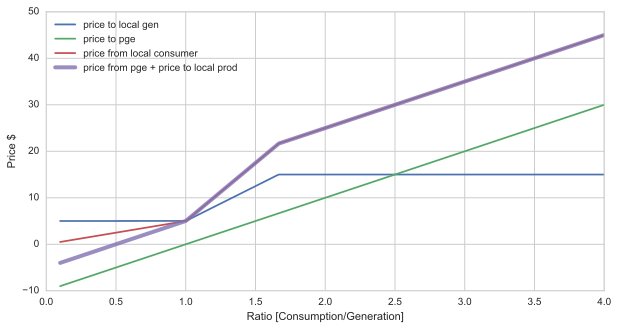

In [3]:
param = {}

# Retailing price $/kW
param['pge'] = 1

# Upper/lower margin coef
param['upper_ratio'] = 1.666
param['lower_ratio'] = 1.0

# Maximum local electricity price
param['maximum_local_sell'] = 1.5 * param['pge']
param['maximum_local_buy'] = param['maximum_local_sell'] * 1 /param['upper_ratio'] + param['pge'] * (1 - 1 /param['upper_ratio'])

# Minimum local electricity prices
param['minimum_local_buy'] = 0.5 * param['pge']
param['minimum_local_sell'] = 0.5 * param['pge']

# bonus
param['ratio_end'] = 4
param['ratio_num'] = 200

market_design(param)